# Taxi Fare Prediction

Hello everybody, today we're gonna try some prediction models on the Kaggle **"New York City Taxi Fare Prediction"**.  
In this challenge, we'll predict the taxi's fare for each ride.  
The dataset provided in the [Kaggel site](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview)

# 0. Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='darkgrid')

The train's size is 5GB, so we may subsample the CSV file.  
I did it with the [*subsample*](https://github.com/paulgb/subsample) package, to randomly take 250K entries (out of 5.5M).

In [212]:
df = pd.read_csv('train_subsample.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                250000 non-null  object 
 1   fare_amount        250000 non-null  float64
 2   pickup_datetime    250000 non-null  object 
 3   pickup_longitude   250000 non-null  float64
 4   pickup_latitude    250000 non-null  float64
 5   dropoff_longitude  249999 non-null  float64
 6   dropoff_latitude   249999 non-null  float64
 7   passenger_count    250000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.3+ MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-05-19 22:49:39.0000003,20.5,2014-05-19 22:49:39 UTC,-73.985474,40.738516,-73.974870,40.793099,4
1,2014-05-13 08:18:00.000000163,30.0,2014-05-13 08:18:00 UTC,-73.970737,40.758497,-73.937903,40.848190,2
2,2011-06-30 15:50:59.0000002,24.1,2011-06-30 15:50:59 UTC,-73.967693,40.756341,-73.975364,40.675990,1
3,2011-02-07 16:00:00.00000066,9.3,2011-02-07 16:00:00 UTC,-73.989772,40.734185,-73.997172,40.756250,3
4,2011-05-07 01:22:00.00000081,9.3,2011-05-07 01:22:00 UTC,-73.980275,40.690055,-73.956537,40.656872,5


The features, as described in the challenge page, are:
* *pickup_datetime* - `timestamp` value indicating when the taxi ride started.
* *pickup_longitude* - `float` for longitude coordinate of where the taxi ride started.
* *pickup_latitude* - `float` for latitude coordinate of where the taxi ride started.
* *dropoff_longitude* - `float` for longitude coordinate of where the taxi ride ended.
* *dropoff_latitude* - `float` for latitude coordinate of where the taxi ride ended.
* *passenger_count* - `integer` indicating the number of passengers in the taxi ride.

Our targer is:  
*fare_amount* - `float` dollar amount of the cost of the taxi ride.

Note that the *key* feature comprised of the *pickup_datetime* plus a unique integer, but it doesn't matter, we'll treat it like an ID.

#  1. EDA

In this section, I going to explore the data.  
My motvation is to get familiar with the features' values, find some correlations and make some visualizations.

First, let's create a histogram of the *passenger_count* and *fare_amount*

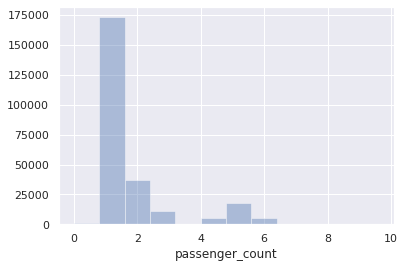

In [3]:
b_width = 0.8
my_bins = np.arange(min(df['passenger_count']), max(df['passenger_count']) + b_width, b_width)
sns.distplot(df['passenger_count'], kde=False, bins=my_bins)

To make the following plot more interpretable, I trimmed outliers (more serious outliers handling will made in [the next section](#2.3-Outliers-detection)

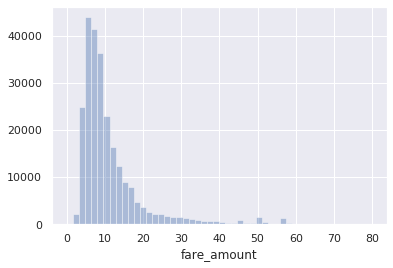

In [4]:
sns.distplot(df[(df['fare_amount'] > 0) & (df['fare_amount'] < 80)]['fare_amount'], kde=False)

And lets see the box:

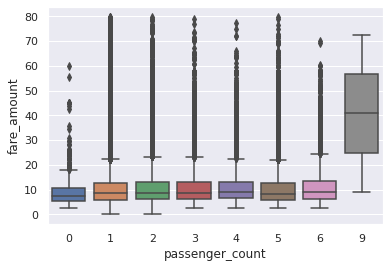

In [5]:
sns.boxplot(x='passenger_count', y='fare_amount', data=df[(df['fare_amount'] > 0) & (df['fare_amount'] < 80)])

Althought we can clearly see the a 9-passengers fare increases dramatically, for now, there's nothing else we can learn on the data untill we do some feature engineering, because the other features are not measurable.  
So, in the next section, we'll see the another EDA process of the new features.

# 2. Feature Engineering

In this section I'd like to create, drop, and tune some of the features.  
The main idea of the FE process is to find more indicative properties of the data, which may ease the learning process of the model.

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                250000 non-null  object 
 1   fare_amount        250000 non-null  float64
 2   pickup_datetime    250000 non-null  object 
 3   pickup_longitude   250000 non-null  float64
 4   pickup_latitude    250000 non-null  float64
 5   dropoff_longitude  249999 non-null  float64
 6   dropoff_latitude   249999 non-null  float64
 7   passenger_count    250000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.3+ MB


Because there's only 1 null value, we can get rid of this entry without any apprehension.

In [7]:
df.dropna(inplace=True)

## 2.1 Times

We have only 1 datetime feature: `pickup_datetime`.  
So, we can't calculate the trip's duration, which intuitively high-correlated to the fare.  
In, addition, we can't assume some "average speed" and use the distances to calculate the duration.  
  
What we can do, is refer to the pickup_datetime components: day of week (weekend?), hour (night fee?) etc. 

In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
interesting_attributes = ['dayofweek', 'hour', 'year', 'month']
for attr in interesting_attributes:
    df[f'pickup_{attr}'] = df['pickup_datetime'].apply(lambda x: getattr(x, attr))

According to [Taxi-Calculator](https://www.taxi-calculator.com/taxi-fare-new-york-city/259), in NYC, night-fare and weekend-fare are between 8pm to 6am, and on Sunday an Saturday.  
so me can make 2 new features: `is_weekend` and `is_night`:

In [10]:
def is_weekend(day):
    return day >= 6 # 6 = Saturday and 7 = Sunday
def is_night(hour):
    return hour >= 20 or hour <= 6

In [11]:
df['is_weekend'] = df['pickup_dayofweek'].apply(is_weekend)
df['is_night'] = df['pickup_hour'].apply(is_night)

In [12]:
df.groupby('pickup_month')['fare_amount'].mean().sort_values()

pickup_month
1     10.751443
2     10.897705
7     11.120039
3     11.143398
8     11.201249
4     11.398822
6     11.478080
12    11.528810
11    11.653664
5     11.672626
10    11.715676
9     11.856588
Name: fare_amount, dtype: float64

It seems like we can add another feature: `quarter`

In [13]:
df['pickup_quarter'] = df['pickup_datetime'].dt.quarter

In [14]:
(df['fare_amount'] > 57.5).sum()

943

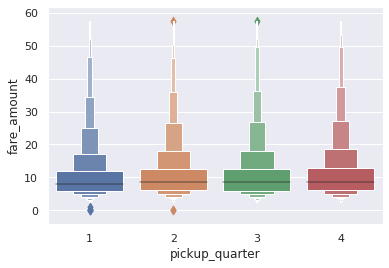

In [15]:
sns.boxenplot(x='pickup_quarter', y='fare_amount', data=df[(df['fare_amount'] > 0) & (df['fare_amount'] < 57.5)])

In [16]:
df.groupby('pickup_quarter')['fare_amount'].mean().sort_values()

pickup_quarter
1    10.934763
3    11.397181
2    11.517901
4    11.633975
Name: fare_amount, dtype: float64

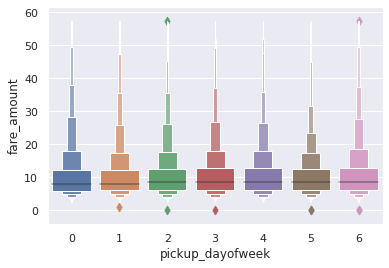

In [17]:
sns.boxenplot(x='pickup_dayofweek', y='fare_amount', data=df[(df['fare_amount'] > 0) & (df['fare_amount'] < 57.5)])

In [18]:
df.groupby('pickup_dayofweek')['fare_amount'].mean().sort_values()

pickup_dayofweek
5    11.040621
1    11.245092
2    11.260838
0    11.370304
4    11.420760
3    11.561383
6    11.661180
Name: fare_amount, dtype: float64

Althougt there're some minor differeces, TBH it's not to indicative.

## 2.2 Location

The 4 geographical feature may help us find interesting patterns.  
In the following sub-section I'll try to find patterns by trips length approximation, division by boroughs etc. 

We can calculate the distance between 2 geographic points using [*haversine formula*](https://en.wikipedia.org/wiki/Haversine_formula):

In [19]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [20]:
df['distance'] = df.apply(
                    lambda row: haversine(
                        row['pickup_longitude'], 
                        row['pickup_latitude'], 
                        row['dropoff_longitude'], 
                        row['dropoff_latitude']),
                    axis=1)

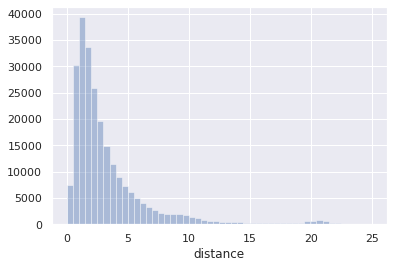

In [21]:
sns.distplot(df[(df['distance'] > 0) & (df['distance'] < 25)]['distance'], kde=False)

Another cool feature we can extract from the geo-location is the boroughs.  
Maybe we can found patterns using this information.  
  
Now, we have to ask ourselves 2 questions:  
1. How can we associate trip to borough?
2. How can we represent this association?  
  
Ok, by quick search in wikipedia, each borough has a "central" geolocation (lat, lon):  
* [`Manhattan`](https://en.wikipedia.org/wiki/Manhattan) - 40.783333, -73.966667
* [`Brooklyn`](https://en.wikipedia.org/wiki/Brooklyn) - 40.624722, -73.952222
* [`Queens`](https://en.wikipedia.org/wiki/Queens) - 40.75, -73.866667
* [`The Bronx`](https://en.wikipedia.org/wiki/The_Bronx) - 40.837222, -73.886111
* [`Staten Island`](https://en.wikipedia.org/wiki/Staten_Island) - 40.571944, -74.146944

We can refer those point as 5 *means*, and accosiate trips by *Haversine distance*.  
Now, about the representation, we'll try 2 options:
1. One categorical feature - with the tag of the closest borough
2. Distance vector - 5 features which each of them is the distance to other borough

In [22]:
boroughs_means = {'Manhattan' : (-73.966667, 40.783333),
                  'Brooklyn' : (-73.952222, 40.624722),
                  'Queens' : (-73.866667, 40.75),
                  'The Bronx' : (-73.886111, 40.837222),
                  'Staten Island' : (-74.146944, 40.571944)}

def multiple_haversine(src, dsts):
    return [haversine(*src, *dst) for dst in dsts]

In [23]:
df[[f'pickup_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()]] = \
df.apply(
    lambda row: multiple_haversine(
        (row['pickup_longitude'], row['pickup_latitude']), 
        boroughs_means.values()), 
    axis=1, result_type='expand')

In [24]:
df[[f'dropoff_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()]] = \
df.apply(
    lambda row: multiple_haversine(
        (row['dropoff_longitude'], row['dropoff_latitude']), 
        boroughs_means.values()), 
    axis=1, result_type='expand')

I'll explain what I've done here:  
From pandas 0.23, you can pass the `apply` function a `result_type` argument. With the `expand` option passed there, apply unpacks the result (given it's iterable) to different columns.  
So, I just assign the results to new columns which I generated by list comprehension, to a form of: `pickup_dist_{borough}` (and dropoff respectively).  

Now let's add a new column of the closest borough category:

In [25]:
df['pickup_closest'] = df[[f'pickup_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()]]\
                        .idxmin(axis=1)\
                        .str.split('dist_')\
                        .apply(lambda x: x[-1])

In [26]:
df['dropoff_closest'] = df[[f'dropoff_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()]]\
                        .idxmin(axis=1)\
                        .str.split('dist_')\
                        .apply(lambda x: x[-1])

And we can identify which trips were cross boroughs:

In [27]:
df['is_cross_borough'] = df['dropoff_closest'] != df['pickup_closest']

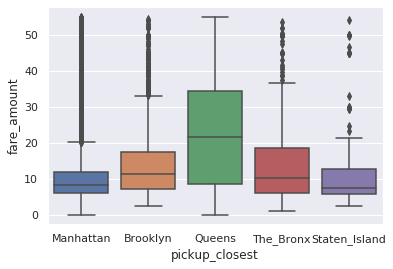

In [28]:
sns.boxplot(x='pickup_closest', y='fare_amount', data=df[(df['fare_amount'] > 0) & (df['fare_amount'] < 55)])

We can certainly see that Queens quarter is the most expensive.  
We hope that cross-borough rides will cost more. let's check it out:

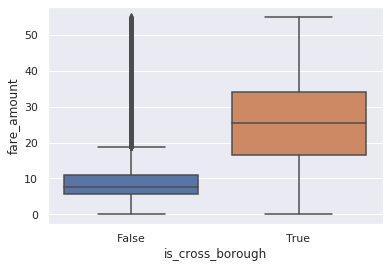

In [29]:
sns.boxplot(x='is_cross_borough', y='fare_amount', data=df[(df['fare_amount'] > 0) & (df['fare_amount'] < 55)])

Tears of joy :*)

## 2.3 Outliers Detection

In the following sub-section we'll try to detect outliers.  
Outlier is an unreasonable sample.  
There are some serious methods for outlire detection (e.g Isolation Forest), but we won't use any of these.  
instead, we just use our common sense to propuse thumb-rules to identify an outlier.  

Let's see the data description:

In [30]:
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,249999.0,11.361621,9.838976,-176.000000,6.000000,8.500000,12.500000,445.000000
passenger_count,249999.0,1.683979,1.309182,0.000000,1.000000,1.000000,2.000000,9.000000
pickup_dayofweek,249999.0,3.034868,1.950707,0.000000,1.000000,3.000000,5.000000,6.000000
pickup_hour,249999.0,13.518450,6.510339,0.000000,9.000000,14.000000,19.000000,23.000000
pickup_year,249999.0,2011.742323,1.861931,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
pickup_month,249999.0,6.260693,3.437084,1.000000,3.000000,6.000000,9.000000,12.000000
pickup_quarter,249999.0,2.421070,1.115718,1.000000,1.000000,2.000000,3.000000,4.000000
distance,249999.0,19.918207,371.863695,0.000000,1.214178,2.115100,3.873910,14887.931252
pickup_dist_Manhattan,249999.0,177.100383,1225.175604,0.082493,2.331962,3.991758,6.149117,15088.003410
pickup_dist_Brooklyn,249999.0,186.842205,1223.118841,0.115113,13.100441,14.645095,16.161947,15071.104918


As we can see, just by looking at the min/max values, there are some unreasonable values.  
We'll delve for each feature, to find its normal range:

###  2.3.1 Fares

In [31]:
df['fare_amount'].describe()

count    249999.000000
mean         11.361621
std           9.838976
min        -176.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         445.000000
Name: fare_amount, dtype: float64

There are some negative value (Hah?), and very high fares.  
We can easily assume that all the negative values are outliers.  
We'll find manually the upper bound:

In [32]:
def find_upper_bound(col, threshold):
    if threshold < 1:
        threshold = threshold * df[col].count()
    for i in range(int(df[col].min()), int(df[col].max()), 10): # non-1 size step for flexibility
        if (df[col] > i).sum() < threshold:
            return i
            
print(find_upper_bound('fare_amount', 1000))

64


So 64$ will be our upper bound.

In [33]:
df = df[(df['fare_amount'] < 64) & (df['fare_amount'] > 0)]

### 2.3.2 Distances

In [34]:
df['distance'].describe()

count    249419.000000
mean         19.651731
std         369.064206
min           0.000000
25%           1.214153
50%           2.112285
75%           3.860784
max       14887.931252
Name: distance, dtype: float64

Again, 0 will be our lower bound, let's search for upper:

In [35]:
print(f'The distance upper bound is: {find_upper_bound("distance", 1000)}')

The distance upper bound is: 30


In [36]:
df = df[(df['distance'] < 30) & (df['distance'] > 0)]

Now let's see the range of the distances from the boroughs:

In [37]:
upper_bounds = [find_upper_bound(i, 1000) for i in [f'pickup_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()]]
for col, b in zip([f'pickup_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()], upper_bounds):
    df = df = df[(df[col] < b) & (df[col] > 0)]

In [38]:
upper_bounds = [find_upper_bound(i, 1000) for i in [f'dropoff_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()]]
for col, b in zip([f'dropoff_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()], upper_bounds):
    df = df = df[(df[col] < b) & (df[col] > 0)]

Let's take another look at the data's description:

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,240988.0,11.134943,8.841618,0.010000,6.000000,8.500000,12.500000,63.500000
pickup_longitude,240988.0,-73.975522,0.034018,-74.094487,-73.992258,-73.982113,-73.968445,-73.682678
pickup_latitude,240988.0,40.750895,0.026545,40.585559,40.736566,40.753382,40.767525,40.886142
dropoff_longitude,240988.0,-73.974439,0.032119,-74.096357,-73.991517,-73.980517,-73.965353,-73.687312
dropoff_latitude,240988.0,40.751484,0.029920,40.572824,40.735943,40.754051,40.768481,40.892353
passenger_count,240988.0,1.683988,1.309181,0.000000,1.000000,1.000000,2.000000,6.000000
pickup_dayofweek,240988.0,3.034342,1.950924,0.000000,1.000000,3.000000,5.000000,6.000000
pickup_hour,240988.0,13.527441,6.506407,0.000000,9.000000,14.000000,19.000000,23.000000
pickup_year,240988.0,2011.744655,1.866323,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
pickup_month,240988.0,6.261237,3.439839,1.000000,3.000000,6.000000,9.000000,12.000000


In [40]:
df.head().T

,0,1,2,3,4
key,2014-05-19 22:49:39.0000003,2014-05-13 08:18:00.000000163,2011-06-30 15:50:59.0000002,2011-02-07 16:00:00.00000066,2011-05-07 01:22:00.00000081
fare_amount,20.5,30,24.1,9.3,9.3
pickup_datetime,2014-05-19 22:49:39+00:00,2014-05-13 08:18:00+00:00,2011-06-30 15:50:59+00:00,2011-02-07 16:00:00+00:00,2011-05-07 01:22:00+00:00
pickup_longitude,-73.9855,-73.9707,-73.9677,-73.9898,-73.9803
pickup_latitude,40.7385,40.7585,40.7563,40.7342,40.6901
dropoff_longitude,-73.9749,-73.9379,-73.9754,-73.9972,-73.9565
dropoff_latitude,40.7931,40.8482,40.676,40.7563,40.6569
passenger_count,4,2,1,3,5
pickup_dayofweek,0,1,3,0,5
pickup_hour,22,8,15,16,1


# 3. Models Comparisons

In this section, I'll finally try some model!  
I'm going to try the traditional models, and some tree-based models. No deep-learning allowed.

In order to be able to run several models in a row, I'll build a generic pipline, which reproduce the process we've done together in the previous section.  
In the first step we need to build the preprocessing and the feature engineering stages.

## 3.1 Preprocessing Pipeline

First, we need to get familiar with some terms:  
- `Pipline`: A defined set of functionalities, performed sequentially, represents our process
- `Transformer`: A transformation function - gets matrix (or vector) a and returns b. We use transformers to apply the feature engineering tricks and buildups
- `FeatureUnion`: Each transformer return a subset of the total feature we want to train the model on, so the FeatureUnion collects all these features and stack them to singel structure

### 3.1.1 Bypass Transformer

In [155]:
from sklearn.base import BaseEstimator, TransformerMixin

class ByPassTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[:, self.cols].reshape(-1,1)

In this transformer, we just bypass the features we don't want to change.

### 3.1.2 Date Features Transformer

In [42]:
class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dates = pd.to_datetime(X[:, self.col])
        years = dates.year.values.reshape(-1,1)
        months = dates.month.values.reshape(-1,1)
        dayofweeks = dates.dayofweek.values.reshape(-1,1)
        hours = dates.hour.values.reshape(-1,1)
        quarters = dates.quarter.values.reshape(-1,1)
        is_weekend = self.is_weekend(dayofweeks)
        is_night = self.is_night(hours)
        return np.concatenate([years, months, dayofweeks, hours, quarters, is_weekend, is_night], axis=1) 
    
    def is_weekend(self, day):
        return (day >= 6).astype(int) # 6 = Saturday and 7 = Sunday
    
    def is_night(self, hour):
        return (np.logical_or((hour >= 20),(hour <= 6))).astype(int)

### 3.1.3 Location Features Transformer

In [157]:
class LocationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, boroughs_means, mode='ovo'):
        self.cols = cols
        self.boroughs_means = boroughs_means
        self.mode = mode
    
    def fit(self, x_loc, y=None):
        return self
    
    def transform(self, X):
        x_loc = X[:, self.cols].astype(float)
        features = []
        distances = self.haversine(x_loc).reshape(-1,1)
        features.append(distances)
        
        distances_from_pickup_to_boroughs = np.apply_along_axis(multiple_haversine, 1,
                                                                x_loc[:,:2], dsts=self.boroughs_means.values())
        
        distances_from_dropoff_to_boroughs = np.apply_along_axis(multiple_haversine, 1,
                                                                 x_loc[:,2:], dsts=self.boroughs_means.values())
        pickup_closest = distances_from_pickup_to_boroughs.argmin(axis=1)
        dropoff_closest = distances_from_dropoff_to_boroughs.argmin(axis=1)
        is_cross_boroughs = (pickup_closest == dropoff_closest).astype(int).reshape(-1,1)
        
        
        if self.mode in ['all', 'ovo']:
            features.append(distances_from_pickup_to_boroughs)
            features.append(distances_from_dropoff_to_boroughs)
            
        if self.mode in ['all', 'cat']:
            
            pickup_closest = self.indices_to_one_hot(pickup_closest, len(self.boroughs_means))
            
            dropoff_closest = self.indices_to_one_hot(dropoff_closest, len(self.boroughs_means))
            features.append(pickup_closest)
            features.append(dropoff_closest)
        
        features.append(is_cross_boroughs)
        
        return np.concatenate(features, axis=1)
        
    
    

    def haversine(self, x_loc):
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = np.radians(x_loc).T

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a)) 
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles
        return c * r
    
    def multiple_haversine(self, src, dsts):
        return [self.haversine(*src, *dst) for dst in dsts]
    
    def indices_to_one_hot(self, data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        targets = np.array(data).reshape(-1)
        return np.eye(nb_classes)[targets]

In these transformers, we apply all the feature extractions and creation from [Section 2](#2.1-Times)

### 3.1.4 Building the Pipeline

Let's get another look at the original data the mark the indices of the features:

In [44]:
list(df.columns)[:8]

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [45]:
passenger_count_idx = 5
date_idx = 0
locations_idx = range(1,5)

Note: the 'key' and 'fare_amount' columns will remove, so the count is from the pickup_datetime column

Now we can write done teh preprocessing pipline:

In [158]:
from sklearn.pipeline import Pipeline, FeatureUnion

preprocess_pipeline = Pipeline([
    ('feature_engineering', FeatureUnion([
        ('date', DateTransformer(col=date_idx)),
        ('location', LocationTransformer(cols=locations_idx, boroughs_means=boroughs_means)),
        ('pssenger_count_bypass', ByPassTransformer(cols=passenger_count_idx))
    ]))
])

For future steps, we'd like to save the features' names of the preprocessing pipeline's output:

In [176]:
preprocessing_features_names = [
    'years', 
    'months', 
    'dayofweeks', 
    'hours', 
    'quarters', 
    'is_weekend', 
    'is_night',
    'trip length'] \
+ [f'pickup_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()] \
+ [f'dropoff_dist_{b.replace(" ", "_")}' for b in boroughs_means.keys()] \
+ ['is_cross_boroughs']

## 3.2 Models Execution

Now we can move to the models!  
We'd like to compare the following models:
* Linear Regression
* Random Forest
* XGBoost
* CatBoost

### 3.2.1 Data arrangment

In [167]:
from sklearn.model_selection import train_test_split

def arrange_data(mode='sample', df=None, path=None, delimiter=',', test_size=0.2, random_state=42 ):
    if mode == 'sample':
        X = df[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 'passenger_count']].to_numpy()
        y = df['fare_amount'].to_numpy()
    elif mode == 'all':
        data = np.genfromtxt(path ,delimiter=delimiter, skip_header=1)
        X = data[:, 2:]
        y = data[:, 1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [169]:
X_train, X_test, y_train, y_test = arrange_data(df=df)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(192790, 6) (192790,) (48198, 6) (48198,)


###  3.2.2 Run the pipeline

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor

regressors = [
    xgb.XGBRegressor(objective="reg:linear", random_state=42, tree_method='gpu_hist', gpu_id=0),
    LinearRegression(),
    RandomForestRegressor(),
    CatBoostRegressor(task_type="GPU", devices='0:1', verbose=0)
    ]

fitted_regressors = []
scores = dict()

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocess_pipeline),
                      ('regressor', regressor)])
    pipe.fit(X_train, y_train)
    print(regressor)
    fitted_regressors.append(regressor)
    train_score = pipe.score(X_train, y_train)
    test_score = pipe.score(X_test, y_test)
    scores[type(regressor).__name__] = {'train': train_score, 'test': test_score}
    print(f"{type(regressor).__name__} train score: %.3f" % train_score)
    print(f"{type(regressor).__name__} test score: %.3f" % test_score)

[08:27:21] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:27:21] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)
XGBRegressor train score: 0.915
XGBRegressor test score: 0.879
LinearRegression(copy_X=True, fit

Let's find the feature importance:

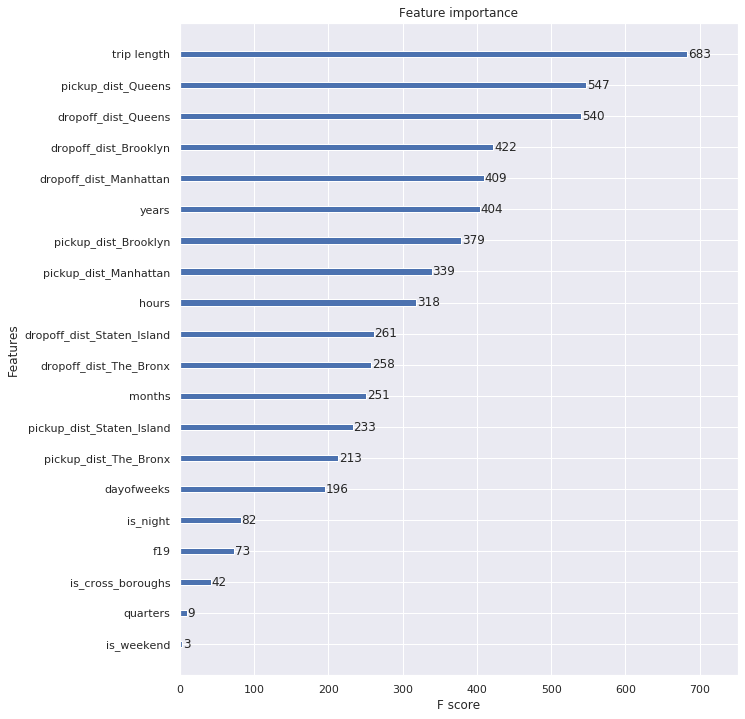

In [186]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(10,12))
xgboost = fitted_regressors[0]
xgboost.get_booster().feature_names = preprocessing_features_names
plot_importance(xgboost, ax=ax)

The Pipeline follows the global sklearn API: fit(), predict(), score(), etc.

### 3.2.3 Test various features

We've got ~0.86 $R^2$ score.  
In order to find the best parameters (we'll focus on the preprocessing parameters, and ignore the RamdomForestRegressor due to the boosted equivalents are better on large datasets), we'll run a `GridSearch`

In [211]:
from sklearn.model_selection import GridSearchCV

regressors_grid = [
    xgb.XGBRegressor(objective="reg:squarederror", random_state=42, tree_method='gpu_hist', gpu_id=0),
    LinearRegression(),
    CatBoostRegressor(task_type="GPU", devices='0:1', verbose=0)
    ]

fitted_regressors_grid = []
scores_grid = dict()

for regressor in regressors_grid:
    pipe = Pipeline(steps=[('preprocessor', preprocess_pipeline),
                      ('regressor', regressor)])
    
    param_grid = {'preprocessor__feature_engineering__location__mode': ['ovo', 'cat', 'all']}
    grid_search = GridSearchCV(pipe, param_grid=param_grid)
    
    grid_search.fit(X_train, y_train)
    print(regressor)
    fitted_regressors_grid.append(regressor)
    train_score = grid_search.score(X_train, y_train)
    test_score = grid_search.score(X_test, y_test)
    scores_grid[type(regressor).__name__] = {'train': train_score, 'test': test_score}
    print(f"{type(regressor).__name__} train score: %.3f" % train_score)
    print(f"{type(regressor).__name__} test score: %.3f" % test_score)
    print(grid_search.best_params_)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=42, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method='gpu_hist', validate_parameters=None, verbosity=None)
XGBRegressor train score: 0.915
XGBRegressor test score: 0.879
{'preprocessor__feature_engineering__location__mode': 'ovo'}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
LinearRegression train score: 0.828
LinearRegression test score: 0.827
{'preprocessor__feature_engineering__location__mode': 'all'}
CatBoostRe

#  4. Conclusions

So, we've found that the XGBoost outperformed the other regressors, and the 'ovo' mode (one-versus-one) got the best score.  
We can dive into the model's parameters, but the main idea of GridScearch conveyed.

# 5. Summary

In this notebook we passed through several steps:
1. EDA - We explored the given data, tried to find interesting patterns
2. Feature Engineering - We create new features from the given data and make some viz
3. Models Comparison - We've built a pipeline which reproduces the feature engineering process, runs different models on the data and compares between them